# Bare Probabilistic strategy for Polynomial prediction with a heterogenous MLP model

### env management

In [1]:
%env "WANDB_NOTEBOOK_NAME" "27_hetero_poly_probabilistic_bare.ipynb"
%env WANDB_SILENT=True
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

env: "WANDB_NOTEBOOK_NAME"="25_hetero_poly_probabilistic.ipynb"
env: WANDB_SILENT=True


### imports and setup

In [2]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

import os
import sys
import time
import logging
import wandb

In [3]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='vlag', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [4]:
class MidpointNormalize(Normalize):
    """
    Normalize and shift the colormap to center 0
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin, vmax, midpoint) = self.vmin, self.vmax, self.midpoint
        if vmin is None or vmax is None:
            vmin, vmax = np.min(value), np.max(value)
        if midpoint is None:
            midpoint = (vmin + vmax) / 2
        result = np.ma.masked_array(np.interp(value, [vmin, midpoint, vmax], [0, 0.5, 1]))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result

### config

In [5]:
jax.config.update('jax_platform_name', 'cpu')

In [6]:
input_size = 1
hidden_sizes = [5, 5] 
min_neurons = 4
output_size = 1
initial_activation_list = [sin, jax.nn.relu, jax.nn.tanh]
activation_list = [sin, jax.nn.relu, jax.nn.tanh]
optimizer = optax.adabelief
bias = False
num_epochs = 25000
intervene_every = 100
seed = 0
key = jax.random.PRNGKey(seed)
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

act_string = "_".join([act.__name__ for act in initial_activation_list])

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

In [7]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'intervene_every': intervene_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [8]:
# jax.config.update("jax_enable_x64", True)

Description = f"Hetero_{act_string}_poly_bare_probabilistic_strat_{optimizer.__name__}_no_bias_min_{min_neurons}_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{intervene_every}_{threshold}_{seed}"
fig_folder = f"../figures/{Description}"
out_folder = f"../output/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

### logging

In [9]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 1
Description: Hetero_sin_relu_tanh_poly_probabilistic_strat_adabelief_no_bias_min_4_5_5_25000_100_0.0001_0
jax backend: cpu
jax devices: [CpuDevice(id=0)]


In [10]:
run = wandb.init(project="neural-network-evolution", name=Description, config=config.__dict__)


### data

In [11]:
def poly(x):
    """
    7th degree polynomial to predict
    """
    return (x - 3)*(x - 2)*(x - 1)*x*(x + 1)*(x + 2)*(x + 3)

In [12]:
x = jnp.linspace(-3, 3, n_samples).reshape(-1, 1)
y = poly(x)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)


Text(0.5, 0.98, 'Data')

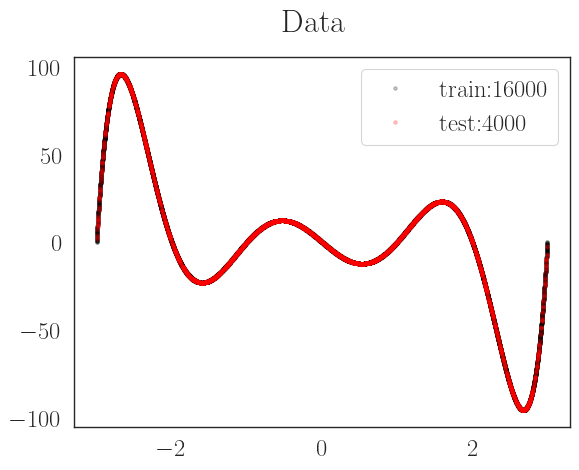

In [14]:
plt.plot(x_train, y_train, "k.", alpha=0.2, label=f"train:{len(x_train)}")
plt.plot(x_test, y_test, "r.", alpha = 0.2, label=f"test:{len(x_test)}")
plt.legend()
plt.suptitle("Data")

### training and eval scheme

In [15]:
def initialize_optimizer_state(mlp, optimizer):
    """
    Optimizer initialization that filters for float arrays in the jax pytrees
    """
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [16]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [17]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [18]:
@eqx.filter_jit()
def test_step(mlp, x, y):
    return compute_loss(mlp, x, y)[0]

In [19]:
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))

### initializing MLP

In [20]:
mlp = CustomMLP(config)
init_neurons = sum(mlp.get_shape())
logging.info(f"Number of neurons at start: {init_neurons}")

Number of neurons at start: 11


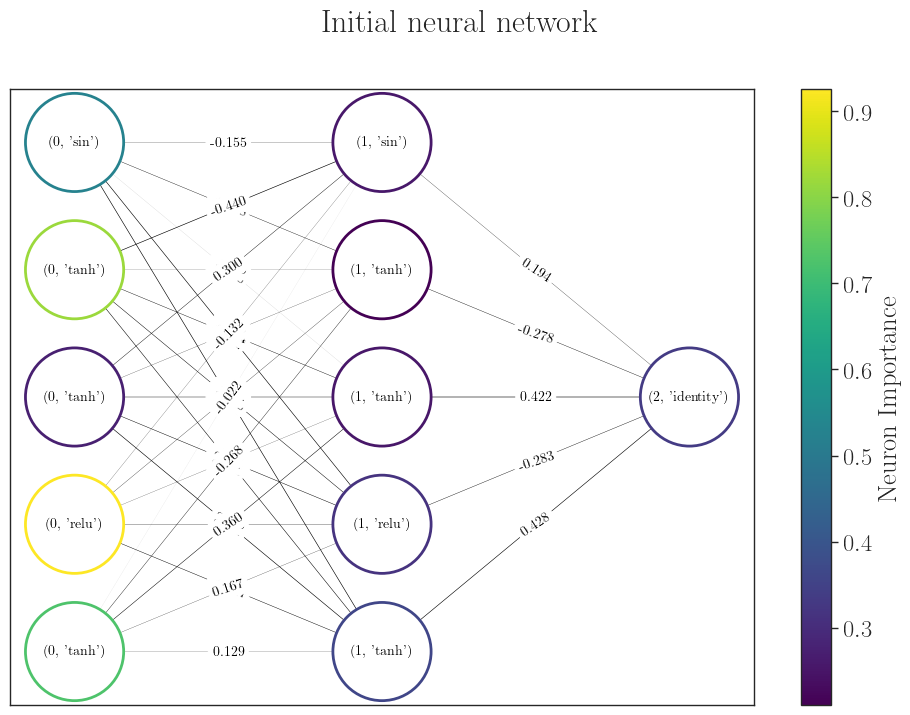

In [21]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.suptitle("Initial neural network")
plt.savefig(f"{fig_folder}/initial_graph.png")
wandb.log({"initial neural network": wandb.Image(plt, caption="initial neural network")})

In [22]:
initial_adjacency_matrix = mlp.adjacency_matrix()

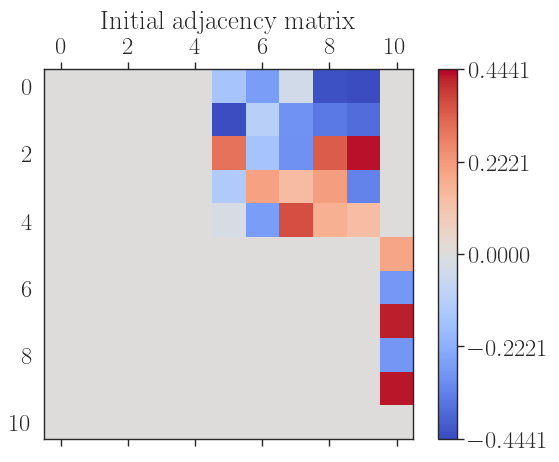

In [23]:
max_wt = np.max(np.abs(initial_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(initial_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
wandb.log({"initial adjacency matrix": wandb.Image(plt, caption="initial adjacency matrix")})

### initializing optimizer

In [24]:
opt = optimizer(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

### training

In [25]:
train_loss_history = []
test_loss_history = []
node_history = []
grad_norm_history = []
graph_history = []
update_history = []
time_history = []

test_loss = np.inf # initialize test loss to infinity
check_loss = np.inf # initialize check loss to infinity

In [26]:
def p_add(test_loss, n_neurons, min_neurons):
    """
    Probability of trying to add a neuron
    """
    return test_loss / (test_loss + n_neurons / min_neurons)

def p_remove(test_loss, n_neurons, min_neurons):
    """
    Probability of trying to remove a neuron
    """
    return test_loss / (test_loss + min_neurons / n_neurons)

In [27]:
for epoch in range(num_epochs):

    start = time.time()
    train_loss, mlp, opt_state = train_step(mlp, x_train, y_train, opt_state, opt.update)
    _, grads  = compute_loss(mlp, x_train, y_train)
    grad_norm_val = grad_norm(grads)
    n_neurons = sum(mlp.get_shape())

    logging.info(f"Epoch {epoch :03d}, Loss: {train_loss.item()}, Neurons: {n_neurons}, Grad norm: {grad_norm_val :.3e}")
    wandb.log({"train_loss": train_loss.item(), "neurons": n_neurons, "grad_norm": grad_norm_val})
    train_loss_history.append((epoch, train_loss))
    grad_norm_history.append((epoch,grad_norm_val))
    node_history.append((epoch, n_neurons))

    if test_loss < threshold: # stop training if test loss is below threshold
        logging.info(f"Threshold reached, stopping training at epoch {epoch}")
        wandb.log({"threshold reached": epoch})
        break

    if grad_norm_val < grad_norm_threshold/10: # stop training if gradient norm is very low
        logging.info(f"Gradient norm below threshold, stopping training at epoch {epoch}")
        wandb.log({"grad_norm_threshold": epoch})
        break

    key, add_key, sub_key, prob_key = jax.random.split(key,4)

    if ((epoch + 1) % intervene_every == 0
        or grad_norm_val < grad_norm_threshold) and epoch!=num_epochs-1: # intervene if gradient norm is below threshold, but not at last epoch
        test_loss = test_step(mlp, x_test, y_test)
        logging.info(f"Epoch {epoch :03d}, Test loss: {test_loss.item()}")
        wandb.log({"test_loss": test_loss.item()})
        test_loss_history.append((epoch,test_loss))

        # Neuron Addition criteria
        if ( jax.random.uniform(prob_key, minval = 0, maxval = 1)< p_add(test_loss, n_neurons, min_neurons)): # addition probability

            add_key, act_key = jax.random.split(add_key)
            activation = activation_list[jax.random.choice(key, jnp.arange(len(activation_list)))]
            layers = len(mlp.get_shape()) - 1
            layer = jax.random.randint(act_key, (1,), 0, layers)[0] # randomly select a layer to add neuron to
            mlp.add_neuron(layer_index=layer, activation=activation, bias = bias, key=add_key)
            opt_state = initialize_optimizer_state(mlp, opt)

            update_history.append((epoch, n_neurons, train_loss, test_loss, activation.__name__, layer))
            logging.info(f"Added neuron to hidden layer {layer+1} with activation {activation.__name__}")
            wandb.log({"added neuron": activation.__name__})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
            check_loss = test_loss
            logging.info(f"Check loss updated to {check_loss}")
        
        # Neuron Removal criteria
        elif (jax.random.uniform(prob_key, minval = 0, maxval = 1)<p_remove(test_loss, n_neurons, min_neurons)): # removal probability 

            layer_key, neuron_key, sub_key = jax.random.split(sub_key,3)
            layer = update_history[-1][-1] # get the layer of last addition
            neuron_idx = len(mlp.layers[layer]) -1

            if len(mlp.layers[layer]) <= 1:
                logging.info(f"Cannot remove neuron from layer {layer+1}, only one neuron left")
                update_history.append((epoch, n_neurons, train_loss, test_loss, "single_node_layer", layer))
                continue

            mlp.remove_neuron(layer_index=layer, neuron_index=neuron_idx)
            opt_state = initialize_optimizer_state(mlp, opt)
            update_history.append((epoch, n_neurons, train_loss, test_loss, "removed", layer))

            logging.info(f"Removed neuron to hidden layer {layer+1} at index {neuron_idx}")
            wandb.log({"removed neuron": neuron_idx})
            logging.info(f"network shape updated to :{mlp.get_shape()}")
    
    stop = time.time()
    time_history.append((epoch, stop-start, n_neurons))



Epoch 000, Loss: 1508.8876953125, Neurons: 11, Grad norm: 4.791e+01
Epoch 001, Loss: 1508.81396484375, Neurons: 11, Grad norm: 4.791e+01
Epoch 002, Loss: 1508.736572265625, Neurons: 11, Grad norm: 4.790e+01
Epoch 003, Loss: 1508.6552734375, Neurons: 11, Grad norm: 4.790e+01
Epoch 004, Loss: 1508.5703125, Neurons: 11, Grad norm: 4.789e+01
Epoch 005, Loss: 1508.4813232421875, Neurons: 11, Grad norm: 4.789e+01
Epoch 006, Loss: 1508.3885498046875, Neurons: 11, Grad norm: 4.788e+01
Epoch 007, Loss: 1508.2921142578125, Neurons: 11, Grad norm: 4.788e+01
Epoch 008, Loss: 1508.1915283203125, Neurons: 11, Grad norm: 4.788e+01
Epoch 009, Loss: 1508.0872802734375, Neurons: 11, Grad norm: 4.787e+01
Epoch 010, Loss: 1507.9793701171875, Neurons: 11, Grad norm: 4.787e+01
Epoch 011, Loss: 1507.86767578125, Neurons: 11, Grad norm: 4.786e+01
Epoch 012, Loss: 1507.752197265625, Neurons: 11, Grad norm: 4.786e+01
Epoch 013, Loss: 1507.633056640625, Neurons: 11, Grad norm: 4.786e+01
Epoch 014, Loss: 1507.510

In [28]:
np.savetxt(f"{out_folder}/neurons.txt", node_history)
np.savetxt(f"{out_folder}/train_loss.txt", train_loss_history)
np.savetxt(f"{out_folder}/test_loss.txt", test_loss_history)
np.savetxt(f"{out_folder}/grad_norm.txt", grad_norm_history)

### evaluation

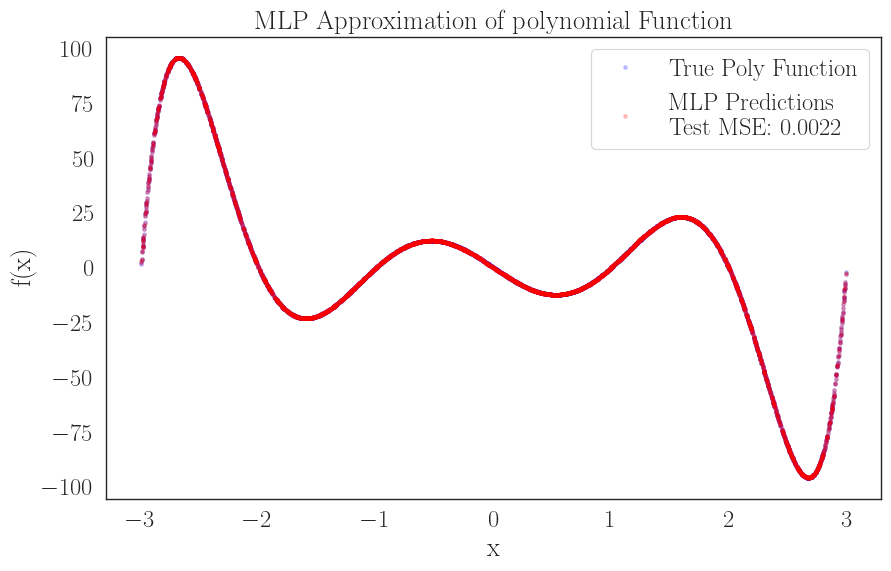

In [29]:
y_pred = jax.vmap(mlp)(x_test)
test_mse = jnp.mean((y_pred - y_test) ** 2)
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, "b.", alpha=0.2, label="True Poly Function")
plt.plot(x_test, y_pred, "r.", alpha=0.2, label="MLP Predictions\n Test MSE: {:.4f}".format(test_mse))
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("MLP Approximation of polynomial Function")
plt.savefig(f"{fig_folder}/polynomial_approximation.png")
wandb.log({"polynomial approximation": wandb.Image(plt, caption="polynomial approximation")})


In [30]:
update_history

[(99,
  11,
  Array(1485.7892, dtype=float32),
  Array(1515.2196, dtype=float32),
  'sin',
  Array(0, dtype=int32)),
 (199,
  12,
  Array(1460.5981, dtype=float32),
  Array(1489.5334, dtype=float32),
  'tanh',
  Array(1, dtype=int32)),
 (299,
  13,
  Array(1441.283, dtype=float32),
  Array(1469.7054, dtype=float32),
  'relu',
  Array(0, dtype=int32)),
 (399,
  14,
  Array(1408.0148, dtype=float32),
  Array(1435.5736, dtype=float32),
  'tanh',
  Array(0, dtype=int32)),
 (499,
  15,
  Array(1374.1527, dtype=float32),
  Array(1400.6693, dtype=float32),
  'relu',
  Array(1, dtype=int32)),
 (599,
  16,
  Array(1346.9966, dtype=float32),
  Array(1372.5983, dtype=float32),
  'sin',
  Array(1, dtype=int32)),
 (699,
  17,
  Array(1290.7112, dtype=float32),
  Array(1314.1008, dtype=float32),
  'relu',
  Array(0, dtype=int32)),
 (799,
  18,
  Array(1195.1781, dtype=float32),
  Array(1213.5228, dtype=float32),
  'relu',
  Array(1, dtype=int32)),
 (899,
  19,
  Array(1132.9636, dtype=float32),
  Ar

In [31]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [32]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

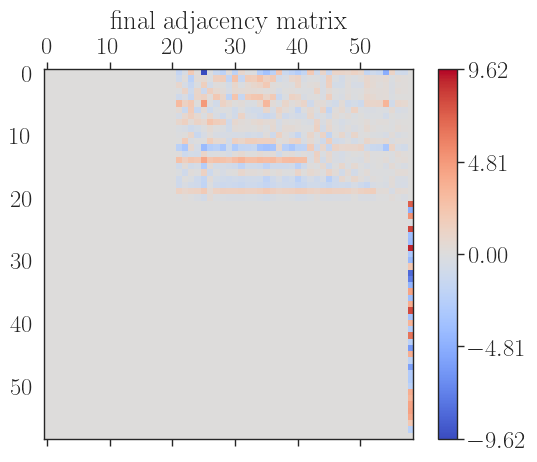

In [33]:
max_wt = np.max(np.abs(final_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(final_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
wandb.log({"final adjacency matrix": wandb.Image(plt, caption="final adjacency matrix")})

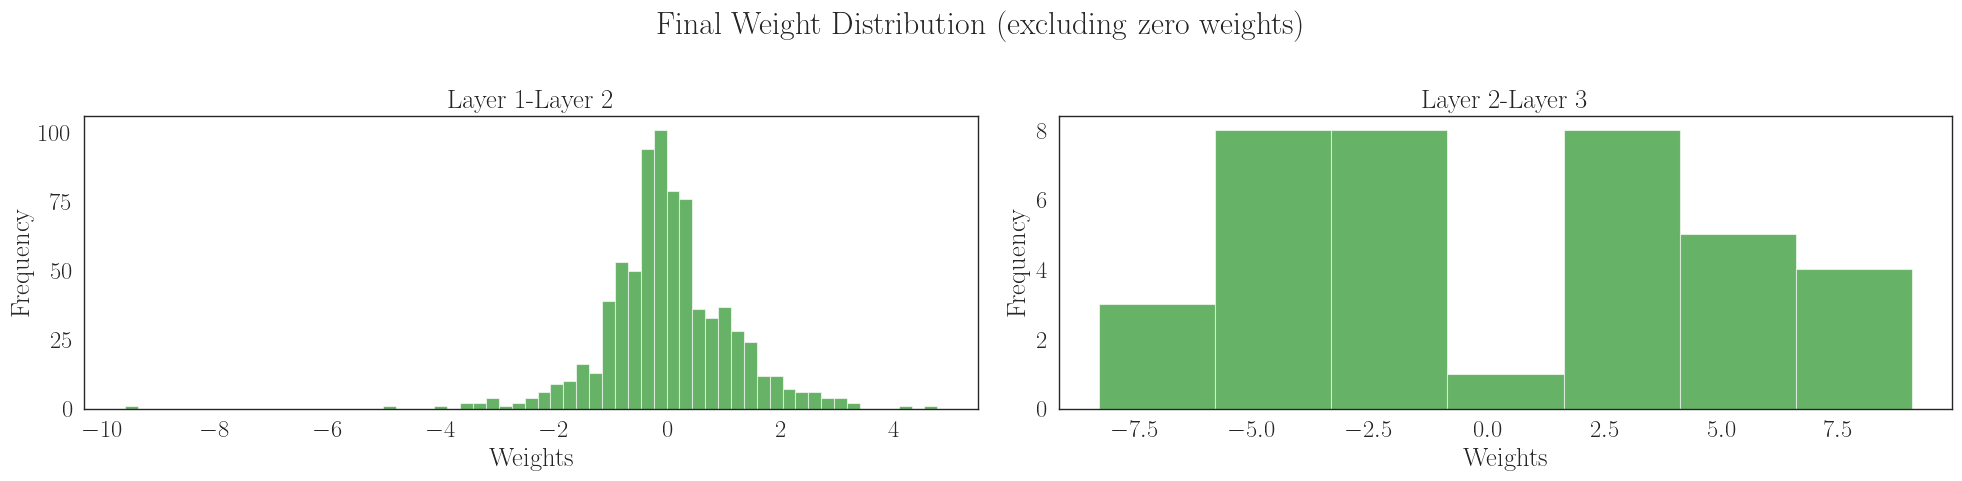

In [34]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum(mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

# Display the figure with its subplots
plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.show()

In [35]:
train_epochs, train_loss = zip(*train_loss_history)
test_epochs, test_loss = zip(*test_loss_history)
grad_epochs, grad_norm_val = zip(*grad_norm_history)
node_epochs, n_neurons = zip(*node_history)

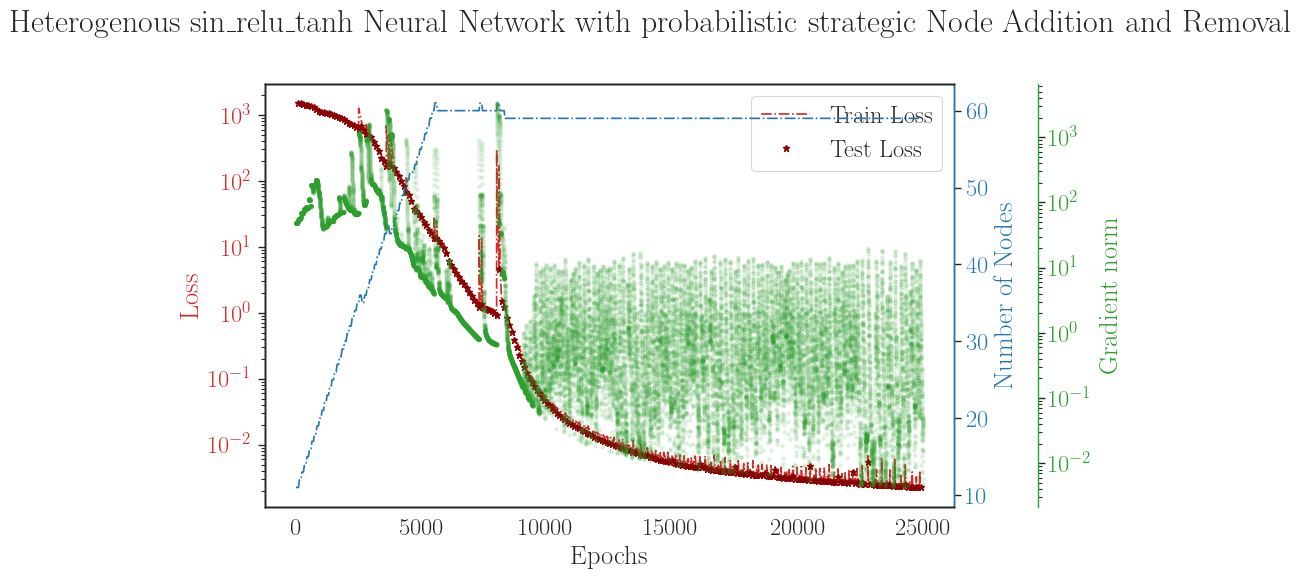

In [36]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

# ax1.set_xscale("log")

plt.suptitle(f"Heterogenous {act_string} Neural Network with bare probabilistic strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve.png")
wandb.log({"loss and nodes": wandb.Image(plt, caption="loss and nodes")})

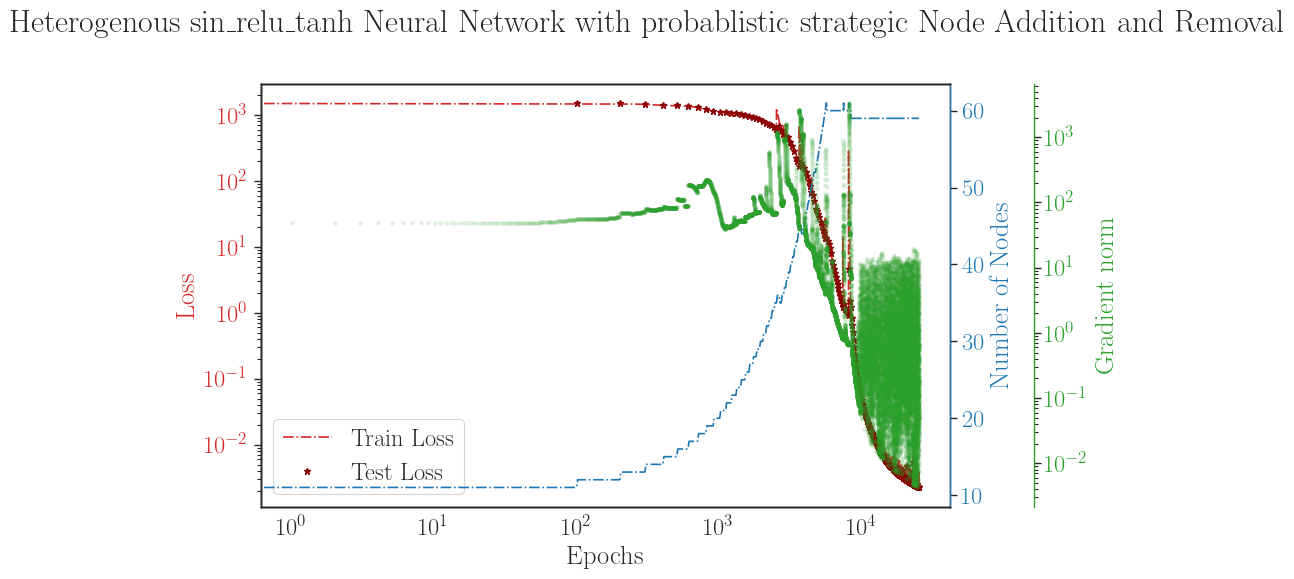

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

ax1.set_xscale("log")

plt.suptitle(f"Heterogenous {act_string} Neural Network with bare probablistic strategic Node Addition and Removal")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve_loglog.png")

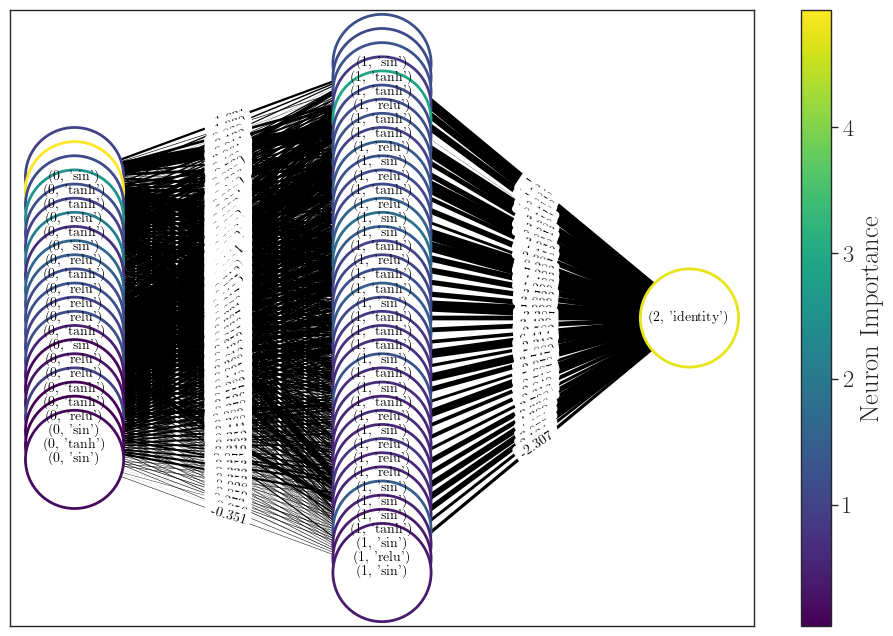

In [38]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
wandb.log({"final neural network": wandb.Image(plt, caption="final neural network")})

In [39]:
wandb.finish()

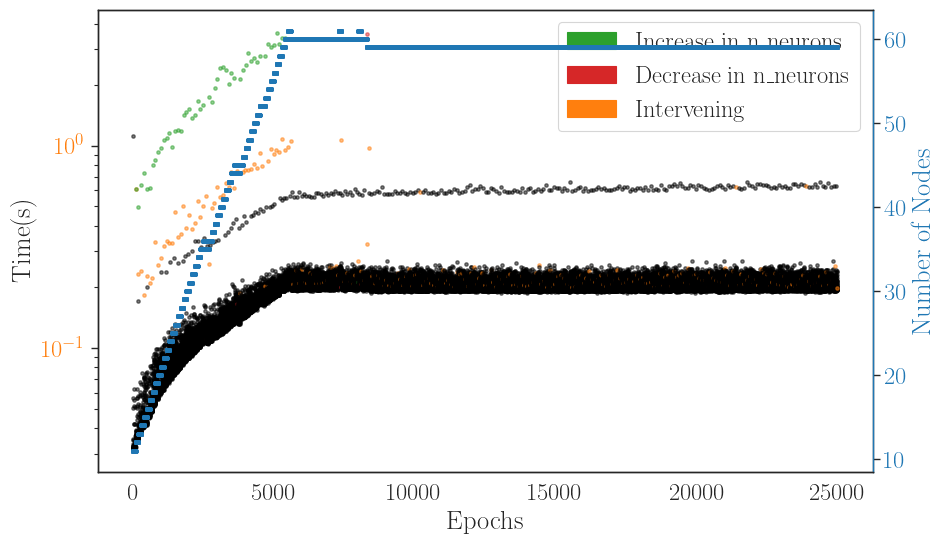

In [40]:
import matplotlib.patches as mpatches
colors = []
epochs, times, n_neurons = zip(*time_history)

diffs = np.diff(n_neurons, prepend=n_neurons[0])

colors = ['tab:green' if diff > 0 else
            'tab:red' if diff < 0 else
            'tab:orange' if (i+1)% intervene_every*int(n_neurons[i]/init_neurons) == 0 else
            'k' for i,diff in enumerate(diffs)]

fig, ax1 = plt.subplots(figsize=(10, 6))

# color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Time(s)')
for epoch, time, color in zip(epochs, times, colors):
    ax1.plot(epoch, time, ".", color=color, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

patches = [
    mpatches.Patch(color='tab:green', label='Increase in n_neurons'),
    mpatches.Patch(color='tab:red', label='Decrease in n_neurons'),
    mpatches.Patch(color='tab:orange', label='Intervening')
]

ax1.legend(handles=patches)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, n_neurons, ".", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)